In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

In [3]:
shared_ds_dir = os.path.join(os.path.dirname(os.getcwd()), "sharedfiles", "train", "*.jpg")

Let me explain what's going on here. I didn't modularlize this code since it's relatively simple performance metrics and practice with tf.data.Dataset.filter. I also didn't want problems with function compilation.

In run one, I filtered based on 'nested_label1' subdir for the dataset.

In run two, I created a dataset of range [0, 100000).

First I found that it took ~6.7sec without a filter to evaluate each number.

It took ~2.8sec for a fresh dataset with a filter using every %5 number, and a autograph filter function.

It took ~3.0sec for a fresh dataset with a filter using every %5 number, without an autograph tag.

These are probably XLA optimized though.

So 2.8 sec vs 6.7sec. That is 40% of the time for 1/5 of the inputs.

Plus it is filtered before it is mapped..

VERY NEGLIGIBLE time considering the organizational benefit.

Actually this doesn't prove that it is filtered before it is mapped. So let's batch
and map.

(The early parts are very messy!!! They are pretty useless anyways, scroll down to the batch statistics!!)

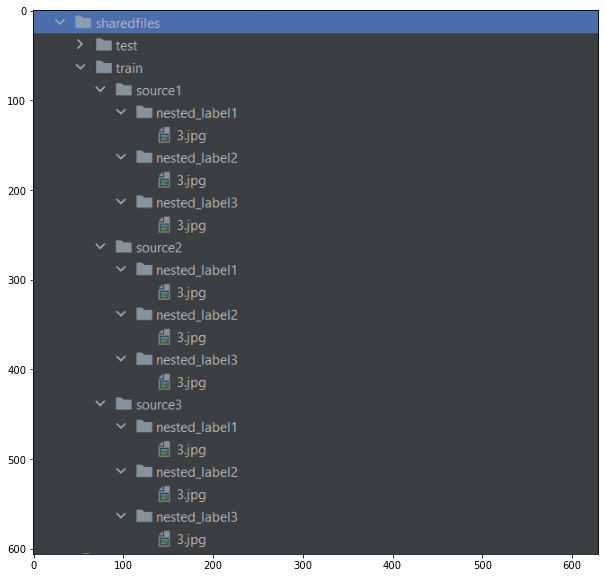

In [4]:
plt.figure(figsize=(12,10))
plt.imshow(plt.imread("architecture.png"))


In [5]:
@tf.function
def filter_imgs(img_fp, target_label):
    fp_split = tf.strings.split(img_fp, "\\")
    nested_label = fp_split[-2]
    return tf.math.equal(nested_label, target_label)


In [6]:
@tf.function
def map_imgs(img_fp):
    img = tf.io.read_file(img_fp)
    img = tf.image.decode_image(img, dtype=tf.float32)[...,:3]
    return img

In [7]:
train_ds = tf.data.Dataset.list_files(shared_ds_dir)

In [8]:
target_label = 'nested_label1'
train_ds = train_ds.filter(lambda fp: filter_imgs(fp, target_label))

In [9]:
train_ds = train_ds.map(map_imgs)

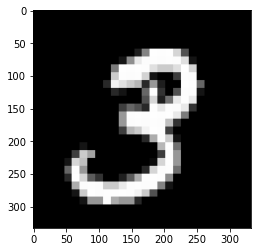

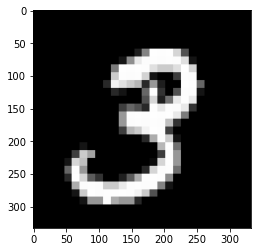

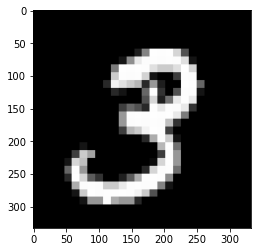

In [10]:
for i, img in train_ds.enumerate():
    plt.imshow(np.asarray(img))
    plt.show()

In [11]:
perf_data = np.arange(100000)

In [12]:
perf_ds = tf.data.Dataset.from_tensor_slices(perf_data)

In [13]:
ctr = time.time()
#in reality you gotta do something with n
for n in iter(perf_ds):
    n == 1
print(abs(ctr-time.time()))

7.192639589309692


In [14]:
perf_data = np.arange(100000)

In [15]:
perf_ds = tf.data.Dataset.from_tensor_slices(perf_data)


In [16]:
@tf.function
def filter_mod5(n):
    return tf.math.equal(n % 5, 0)

In [17]:
perf_ds = perf_ds.filter(filter_mod5)

In [18]:
ctr = time.time()
#in reality you gotta do something with n
for n in iter(perf_ds):
    n == 1
print(abs(ctr-time.time()))

2.9224958419799805


In [19]:
perf_data = np.arange(100000)

In [20]:
perf_ds = tf.data.Dataset.from_tensor_slices(perf_data)


In [21]:
def filter_mod5(n):
    return tf.math.equal(n % 5, 0)

In [22]:
perf_ds = perf_ds.filter(filter_mod5)

In [23]:
ctr = time.time()
#in reality you gotta do something with n
for n in iter(perf_ds):
    n == 1
print(abs(ctr-time.time()))

2.729830026626587


### Filter-map vs map performances below

In [24]:
perf_data = np.arange(100000)

In [25]:
perf_ds = tf.data.Dataset.from_tensor_slices(perf_data)


In [26]:
@tf.function
def filter_mod5(n):
    return tf.math.equal(n % 5, 0)

In [53]:
@tf.function
def map_x3(n):
    for i in range(20000):
        n==i
    return n * 3

perf_ds = perf_ds.filter(filter_mod5)

In [54]:
perf_ds = perf_ds.map(map_x3)
clear_output()

filter-map: 18sec

In [55]:
ctr = time.time()
ct = 0
#in reality you gotta do something with n
for n in iter(perf_ds):
    n == 1
    ct += 1
print(abs(ctr-time.time()))

18.676945209503174


In [56]:
ct


20000

In [59]:
perf_data = np.arange(100000)
perf_ds = tf.data.Dataset.from_tensor_slices(perf_data)
perf_ds = perf_ds.map(map_x3)
clear_output()

map: 16.78sec

In [60]:
ctr = time.time()
ct = 0
#in reality you gotta do something with n
for n in iter(perf_ds):
    n == 1
    ct += 1
print(abs(ctr-time.time()))

16.78232717514038


In [ ]:
perf_ds = tf.data.Dataset.from_tensor_slices(perf_data)
perf_ds = perf_ds.map()

SO: for a super-long map function, the filter vs filter-map has similar runtime...

Keep in mind that these mappings don't take very long to begin with..

Now why not try to see what happens when we batch them?

filter-map: 9sec

In [66]:
@tf.function
def map_x3(n):
    for i in range(20000):
        n==i
    return n * 3
@tf.function
def filter_mod5(n):
    return tf.math.equal(n % 5, 0)
perf_data = np.arange(100000)
perf_ds = tf.data.Dataset.from_tensor_slices(perf_data)
perf_ds = perf_ds.filter(filter_mod5)
perf_ds = perf_ds.map(map_x3)
clear_output()
perf_ds = perf_ds.batch(40)

In [67]:
def run_metrics(ds):
    ctr = time.time()
    ct = 0
    #in reality you gotta do something with n
    for n in iter(ds):
        n == 1
        ct += 1
    print(abs(ctr-time.time()))

In [68]:
run_metrics(perf_ds)

9.14880895614624


map: 9sec

In [ ]:
run_metrics(perf_ds)

In [70]:
@tf.function
def map_x3(n):
    for i in range(20000):
        n==i
    return n * 3
perf_data = np.arange(100000)
perf_ds = tf.data.Dataset.from_tensor_slices(perf_data)
perf_ds = perf_ds.map(map_x3)
clear_output()
perf_ds = perf_ds.batch(40)

In [71]:
def run_metrics(ds):
    ctr = time.time()
    ct = 0
    #in reality you gotta do something with n
    for n in iter(ds):
        n == 1
        ct += 1
    print(abs(ctr-time.time()))

map: 9sec

In [72]:
run_metrics(perf_ds)

9.052227973937988
